# 🔄Анализ параметров поездок пользователей сервиса GoFast (электросамокаты)

🔄 Задача: проверить гипотезы, которые могут помочь бизнесу вырасти, такие как:
- тратят ли пользователи с подпиской больше времени на поездки?
- можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? (3130 метров — оптимальное с точки зрения износа самоката).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl

🔄

In [ ]:
from math import sqrt
from scipy import stats as st
from matplotlib import pyplot as plt
from scipy.stats import binom

<font color='green'>
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

без подписки; <br>
·	абонентская плата отсутствует; <br>
·	стоимость одной минуты поездки — 8 рублей; <br>
·	стоимость старта (начала поездки) — 50 рублей; <br>

с подпиской Ultra  <br>
·	абонентская плата — 199 рублей в месяц; <br>
·	стоимость одной минуты поездки — 6 рублей; <br>
·	стоимость старта — бесплатно. <br>

#### Шаг 1. Загрузка данных

<font color='green'>
Пользователи — users_go.csv<br>
	<br>
user_id	- уникальный идентификатор пользователя<br>
name	- имя пользователя<br>
age	- возраст<br>
city -	город<br>
subscription_type	- тип подписки (free, ultra)<br>

In [ ]:
users_go = pd.read_csv('users_go.csv')
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<font color='green'>
Поездки — rides_go.csv<br>
<br>
user_id - уникальный идентификатор пользователя <br>
distance - расстояние, которое пользователь проехал в текущей сессии (в метрах) <br>
duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку» <br>
date - дата совершения поездки <br>

In [ ]:
rides_go = pd.read_csv('rides_go.csv')
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<font color='green'>
Подписки — subscriptions_go.csv<br>
	<br>
subscription_type	тип подписки <br>
minute_price	стоимость одной минуты поездки по данной подписке <br>
start_ride_price	стоимость начала поездки <br>
subscription_fee	стоимость ежемесячного платежа <br>

In [ ]:
subscriptions_go = pd.read_csv('subscriptions_go.csv')
subscriptions_go

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<font color='green'>
🔄    Посмотрим информацию о типах данных и количестве строк.
<font>

In [ ]:
users_go.info() #в таблице о пользователях

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [ ]:
rides_go.info() #в таблице о поездках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


🔄    <font color='green'>Выводы по загрузке данных: <br>
1) Строки с пропущенными данными отсутствуют<br>
2) Количество строк с данными о пользователях 1565, при том что строк с данными о поездках 18068.<br>
Надо совместить данные и проверить соответствие id. Сделаем это в пункте 4 исследования.<br>
3) Формат даты не соответствует формату pandas datetime64[ns]

#### Шаг 2. Предобработка данных

<font color='green'> 2.1 Приведём столбец date к типу даты с формата object на формат pandas datetime64[ns]. </font>

In [ ]:
rides_go['date'] = pd.to_datetime(rides_go['date']) # , format = '%Y/%m/%dT'
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


<font color='green'> 2.2 Создадим новый столбец с номером месяца на основе столбца date. </font>

In [ ]:
rides_go['month'] = rides_go['date'].dt.month
rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


<font color='green'>🔄    Проверим за какой период представлены данные в базе.

In [ ]:
max_date = rides_go['date'].max()
min_date = rides_go['date'].min()
print(f'Минимальная дата {min_date}, максимальная дата {max_date}')

Минимальная дата 2021-01-01 00:00:00, максимальная дата 2021-12-30 00:00:00


<font color='green'>🔄    Данные представлены за год, поэтому при группировке по месяцам, ошибок не будет.

<font color='green'> 2.3 Проверим наличие пропущенных значений и дубликатов в датафреймах. Обработаем их, если такие значения присутствуют. </font>


Согласно данным .info() пропусков цифровых значений в таблицах rides_go и users_go нет. Проверим:

In [ ]:
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [ ]:
users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

<font color='green'> Проверим данные на дубликаты</font><br>

In [ ]:
rides_go[rides_go.duplicated()]

,user_id,distance,duration,date,month


<font color='green'> Дубликатов в данных о поездках нет.</font><br>

In [ ]:
users_go[users_go.duplicated()].head()

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free


<font color='green'> Выше найдены дубликаты в данных о пользователях. Нужно их удалить</font><br>

In [ ]:
users_go.duplicated().sum()

31

In [ ]:
users_go = users_go.drop_duplicates()
users_go.duplicated().sum()

0

<font color='green'>🔄    Вывод о результатах предобработки: <br>
    1. Формат данных о датах поехдок в таблице rides_go исправлен на формат pandas datetime64[ns]. Данные о поездках собраны за 2021 год с 1-го января по 30 декабря. Создан новый столбец данных month (месяц поездки).<br>
    2. Найдены полные дубликаты о пользователях сервиса. Всего 31, что составляет 2% от общего количества. Удалены.<br>
    3. Пропусков данных в таблицах о пользователях и поездках - нет.<br>
    

#### Шаг 3. Исследовательский анализ данных

<font color='green'> Опишите и визуализируйте общую информацию о пользователях и поездках:</font><br>

<font color='green'> 3.1 Частота встречаемости городов</font><br>
<font color='green'>🔄  

In [ ]:
# users_go.groupby('city')['city'].count() - исправил
users_go['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

<font color='green'>🔄  Посмотрим на распредение визуально:

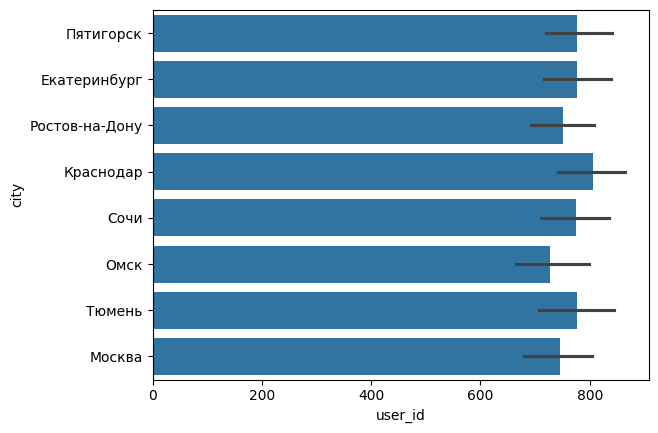

In [ ]:
ax = sns.barplot(data =users_go, y ='city', x ='user_id',
                 order =users_go.groupby('city')['user_id'].agg('count').sort_values(ascending=False).index)

<font color='green'> 3.2 Соотношение пользователей с подпиской и без подписки </font><br>

In [ ]:
# users_go.groupby('subscription_type')['subscription_type'].count()
users_go['subscription_type'].value_counts()

subscription_type
free     835
ultra    699
Name: count, dtype: int64

In [ ]:
print(f'На каждого пользователя с подпиской приходится {835/699} пользователей без подписки')

На каждого пользователя с подпиской приходится 1.1945636623748213 пользователей без подписки


<font color='green'> Тенденция, которой имеет смысл воспользоваться.<br>

<div class="alert alert-block alert-danger">
    
Встречаемость городов и соотношение пользователей необходимо визуализировать. Встречаемость городов хорошо отразит горизонтальный барплот с сортировкой по убыванию, а для визуализации соотношения пользователей отлично подойдет круговая диаграмма с отображением на ней соотношения групп пользователей в %</div>

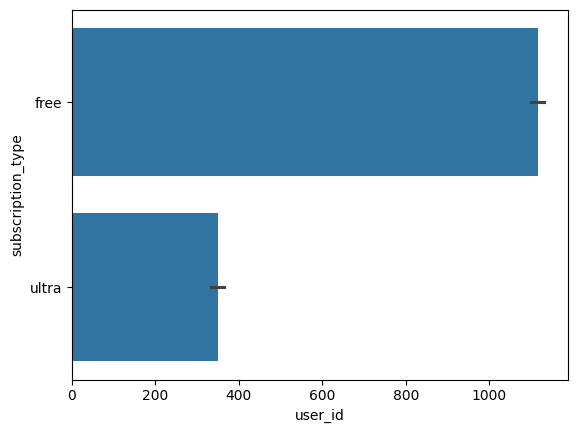

In [ ]:
ay = sns.barplot(data =users_go, y ='subscription_type', x ='user_id',
                 order =users_go.groupby('subscription_type')['user_id'].agg('count').sort_values(ascending=False).index)

<font color='green'> 3.3 Возраст пользователей<br>

In [ ]:
users_go.groupby('age')['age'].count()

age
12      4
13      8
14      9
15     13
16     19
17     26
18     46
19     47
20     71
21     93
22    119
23    129
24    132
25    145
26    131
27    119
28    112
29     68
30     68
31     48
32     41
33     39
34     19
35     15
36      6
37      2
38      3
39      1
43      1
Name: age, dtype: int64

In [ ]:
len(users_go.groupby('age')['age'].count())

29

In [ ]:
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

<font color='green'>🔄  Средний возраст пользователя почти 25 лет.

<div class="alert alert-block alert-warning">

В качестве дополнительного инструмента для анализа можно использовать `describe()`</div>

Text(0, 0.5, 'Количество')

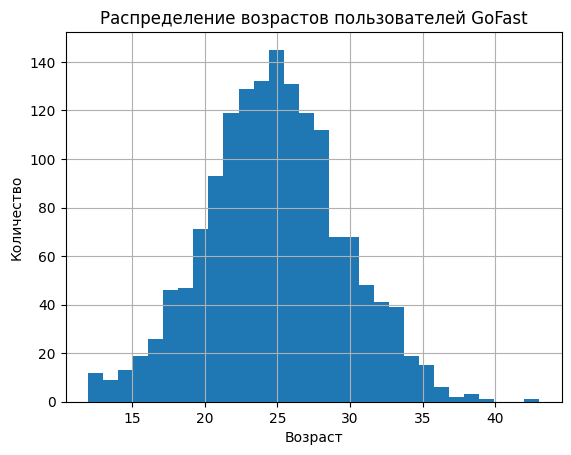

In [ ]:
users_go['age'].hist(bins=30)
pl.title("Распределение возрастов пользователей GoFast")
pl.xlabel("Возраст")
pl.ylabel("Количество")

<font color='green'>Возраст пользователей отражается нормальным распределением. Ожидаемо.<br>
    <font color='green'>🔄 96% пользователей имеют возраст в диапазоне от 15 до 35 лет

In [ ]:
users_go.query('15 < age < 35').info()

<class 'pandas.core.frame.DataFrame'>
Index: 1472 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1472 non-null   int64 
 1   name               1472 non-null   object
 2   age                1472 non-null   int64 
 3   city               1472 non-null   object
 4   subscription_type  1472 non-null   object
dtypes: int64(2), object(3)
memory usage: 69.0+ KB


<font color='green'> 3.4 Расстояние, которое пользователь преодолел за одну поездку.<br>

Text(0, 0.5, 'Количество')

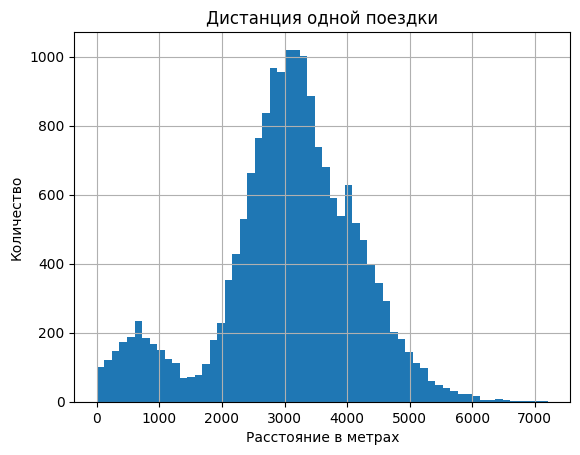

In [ ]:
rides_go['distance'].hist(bins=60)
pl.title("Дистанция одной поездки")
pl.xlabel("Расстояние в метрах")
pl.ylabel("Количество")

<font color='green'>Наблюдается два нормальных распределения, которые должны отражать два процесса.<br>
Пользователи едут до 500 метров, а потом до 3000?..

<br>

<div class="alert alert-block alert-warning">
Чем можно объяснить эти два пиковых значения на распределении?</div>

<font color='green'>🔄 Две гипотезы: <br>
    1) В каком то городе ехать некуда, город маленький;<br>
    2) Ограничения заряда.<br>

<font color='green'> 3.5 Продолжительность поездок </font><br>

Text(0, 0.5, 'Количество')

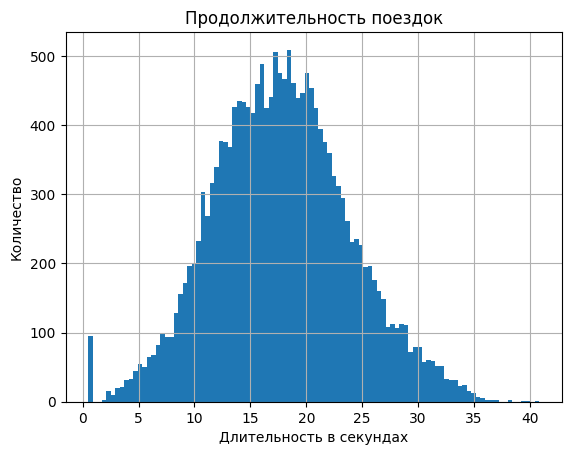

In [ ]:
rides_go['duration'].hist(bins=100)
pl.title("Продолжительность поездок")
pl.xlabel("Длительность в секундах")
pl.ylabel("Количество")

<font color='green'>Максимальное количество поездок в основной массе длится около 15-20 минут<br>

In [ ]:
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

<font color='green'>Среднее время и медиана (по 50% процентилю) - 17 минут. Самые длинные поездки длятся до 40 минут, самые короткие 30 секунд. <br>

<font color='blue'>🔄 Посмотрим другие зависимости (Аномалии), которые есть в таблице rides_go.<br>
    1) user_id - странное увеличение количества поездок для пользователей с id выше 700;<br>
    2) distance - два ярко выраженных распределения;<br>
    3) duration - странные поездки длительностью около 30 сек;<br>
    4) date - странная равномерность поездок. Зимой должно быть меньше;<br>
    5) month - без странностей;<br>
    
    Картина ясней не стала, поищем причины после объединения данных.

array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'distance'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'date'}>],
       [<Axes: title={'center': 'month'}>, <Axes: >]], dtype=object)

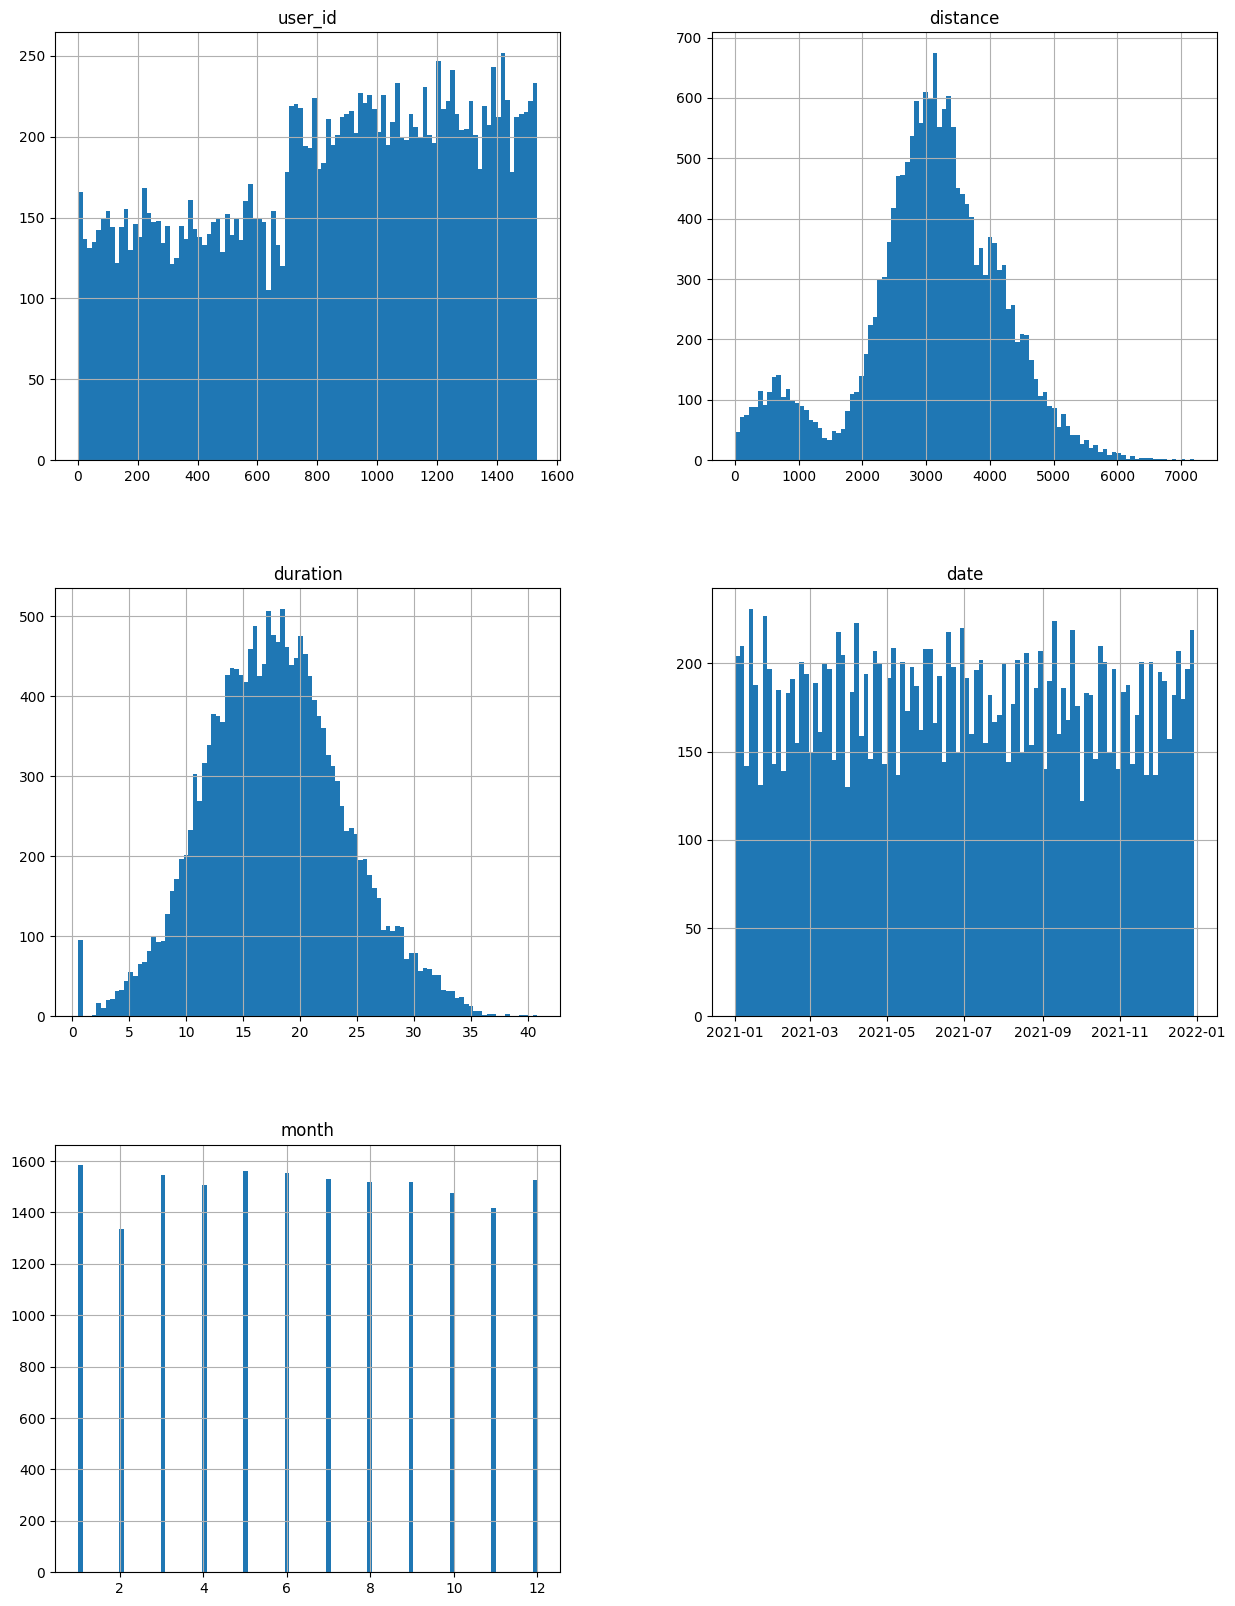

In [ ]:
rides_go.hist(bins=100, figsize=(15, 20))

<font color='green'>🔄 Выводы по исследовательскому анализу данных: <br>
    - Больше всего пользователей в Пятигорске, меньше всего в Москве;<br>
    - Пользователей с подпиской ultra - 699, без подписки free - 835;<br>
    - Средний возраст пользователя почти 25 лет, а в 40 уже почти никто не пользуется сервисом;<br>
    - 96% пользователей сервиса имеют возраст от 15 до 35 лет.<br>
    - В среднем проезжают 3 км, но бывает и до 6 км едут;<br>
    - Максимальное количество поездок в основной массе длится около 15-20 минут. Максимум 35 минут;<br>
    - <font color='blue'>Есть странности в данных, которые объяснить сложно без их объединения.<br>

#### Шаг 4. Объединение данных

<font color='green'><font color='green'> 4.1 Объединим данные о пользователях, поездках и подписках в один датафрейм. <br>
Таблицы rides_go и users_go будем соединять по параметру 	user_id, а данные о расходах через subscription_type.<br>
Общую базу назовем data_go_price<br>


<font color='green'>🔄 Исходные данные выглядят так:

In [ ]:
rides_go.head(1)

,user_id,distance,duration,date,month
0,1,4409.91914,25.599769,2021-01-01,1


In [ ]:
users_go.head(1)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra


In [ ]:
subscriptions_go.head(2)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<font color='green'>🔄 Соединим данные о пользователях и данные об их поездках:

In [ ]:
data_go = rides_go.merge(users_go, on='user_id', how='left')
data_go.head(1)

,user_id,distance,duration,date,month,name,age,city,subscription_type
0,1,4409.91914,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra


<font color='green'>🔄 <font color='green'> Добавим также данные о расходах <br>

In [ ]:
data_go_price = data_go.merge(subscriptions_go, on='subscription_type', how='left')
data_go_price.head(1)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.91914,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199


<font color='green'>🔄 Проверим получившуюся таблицу: <br>

In [ ]:
data_go_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int32         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


<div class="alert alert-block alert-warning">

Тут стоит сравнить количество строк полученной таблицы  с количеством строк таблиц до объединения, чтобы убедиться что мы ничего не потеряли и не добавили лишнего.

</div>

<font color='green'>🔄 Данные итегрированы корректно: в таблице о поездках, к которой мы подсоединяли другие данные (о пользователях и тратах) было 18068 строк и в итоговой таблице осталось 18068 строк.

<font color='green'>  4.2 Создим ещё два датафрейма из датафрейма, созданного на этапе 4.1:<br>
·	c данными о пользователях без подписки;<br>
·	с данными о пользователях с подпиской.<br>

In [ ]:
data_go_free = data_go_price.query('subscription_type == "free"') # пользователи без подписки
data_go_ultra = data_go_price.query('subscription_type == "ultra"') # пользователи с подпиской

<font color='green'> 4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий. <br>

<font color='green'>🔄 Посмотрим распределение дальностей пробега пользователей с подпиской и без подписки.

Text(0, 0.5, 'Количество заездов')

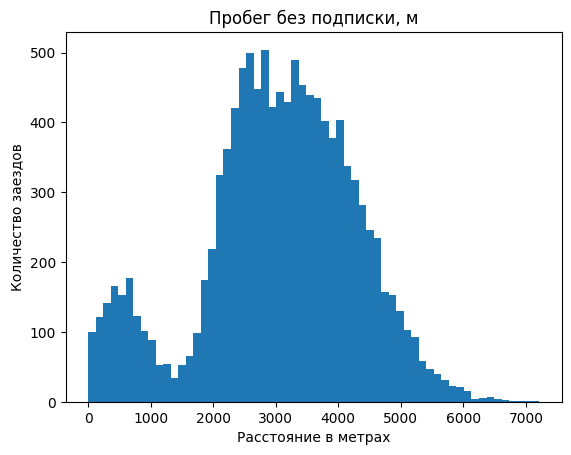

In [ ]:
data_go_free['distance'].plot (kind='hist', bins=60, title='Пробег без подписки, м')
pl.xlabel("Расстояние в метрах")
pl.ylabel("Количество заездов")

Text(0, 0.5, 'Количество заездов')

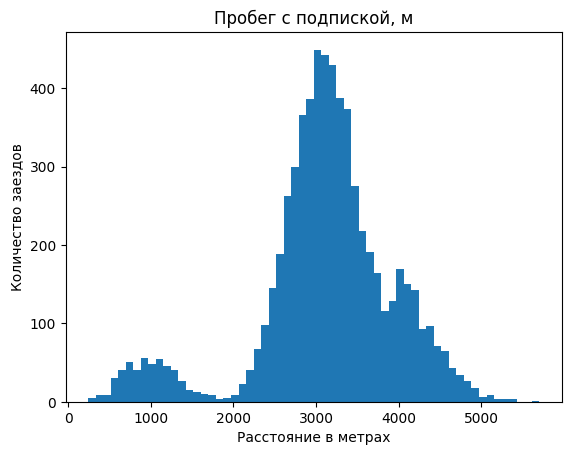

In [ ]:
data_go_ultra['distance'].plot (kind='hist', bins=60, title='Пробег с подпиской, м')
pl.xlabel("Расстояние в метрах")
pl.ylabel("Количество заездов")

<div class="alert alert-block alert-warning">
Распределения для обеих групп пользователей можно объединить для наглядности, наложив их друг на друга.</div>

<font color='green'>🔄 Наложим два графика друг на друга для наглядности:

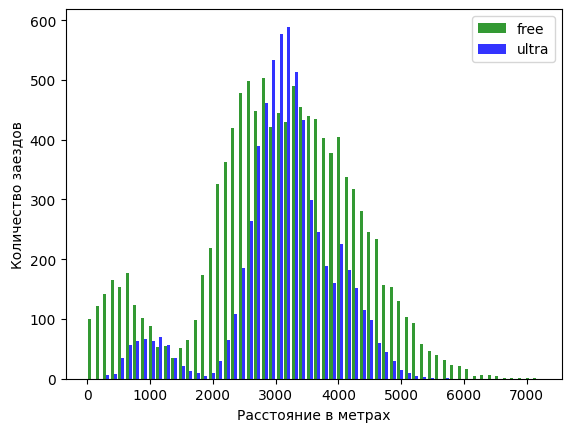

In [ ]:
plt.hist([data_go_free['distance'], data_go_ultra['distance']], color=['green', 'blue'], alpha=0.8, bins=60, label= ['free', 'ultra'])
plt.legend()
pl.xlabel("Расстояние в метрах")
pl.ylabel("Количество заездов")
plt.show()

<font color='green'>🔄 Вывод: явно выраженные распределения, в целом повторяют формы, а значит факторы вызывающие их появление не зависят от подписки.

<font color='green'>🔄 Посмотрим распределение длительностей поездок пользователей с подпиской и без подписки.

Text(0, 0.5, 'Количество заездов')

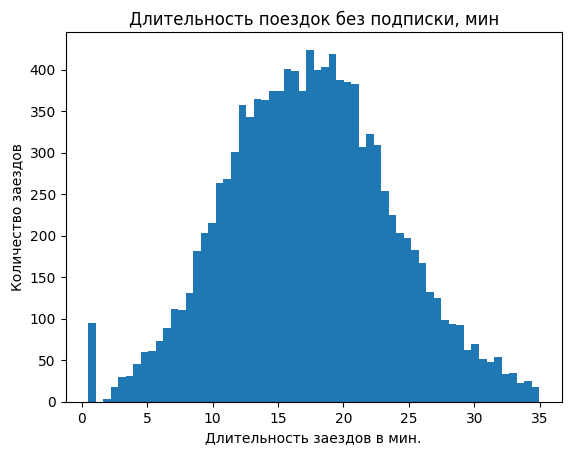

In [ ]:
data_go_free['duration'].plot (kind='hist', bins=60, title='Длительность поездок без подписки, мин')
pl.xlabel("Длительность заездов в мин.")
pl.ylabel("Количество заездов")

<font color='green'> Длительность поездок с подпиской. <br>

Text(0, 0.5, 'Количество заездов')

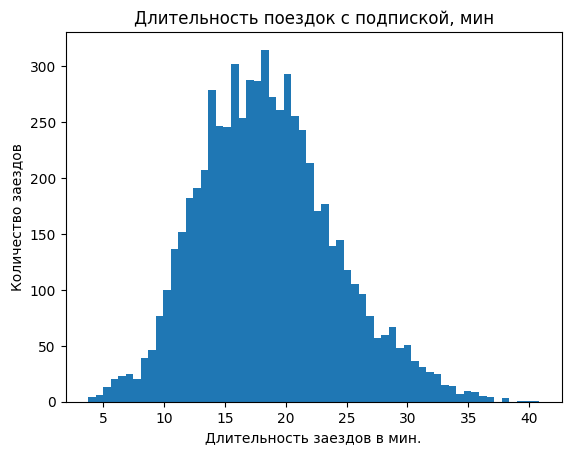

In [ ]:
data_go_ultra['duration'].plot (kind='hist', bins=60, title='Длительность поездок с подпиской, мин')
pl.xlabel("Длительность заездов в мин.")
pl.ylabel("Количество заездов")

<font color='green'>🔄 Наложим два графика друг на друга для наглядности:

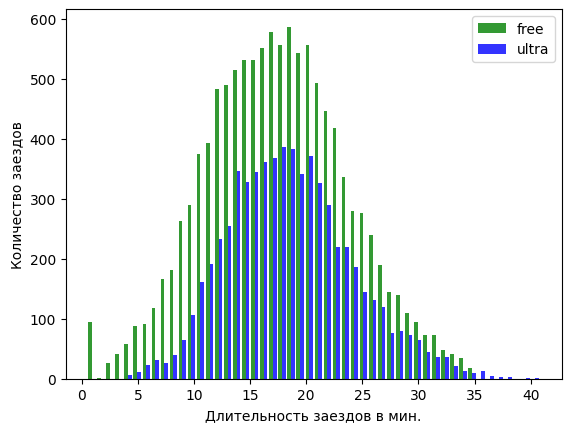

In [ ]:
plt.hist([data_go_free['duration'], data_go_ultra['duration']], color=['green', 'blue'], alpha=0.8, bins=50, label= ['free', 'ultra'])
plt.legend()
pl.xlabel("Длительность заездов в мин.")
pl.ylabel("Количество заездов")
plt.show()

<font color='green'>🔄 Вывод: длительность поездок подчинена закону нормального распределения. <br>
    Пользователи без подписки совершают более короткие поездки, распределение смещено влево. <br>

<div class="alert alert-block alert-danger">
   
 - В чем отличие этих распределений продолжительности поездок?</div>

<font color='blue'>🔄 Рассмотрим аномалию №3. <br>
Пользователи без подписки совершают короткие заезды длительностью в 30 секунд. Возможно это бесплатные пробные поездки? <br> Посмотрим на поездки длительностью до минуты. <br>

In [ ]:
data_go_free.query('0 < duration < 1').info()

<class 'pandas.core.frame.DataFrame'>
Index: 95 entries, 6531 to 17909
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            95 non-null     int64         
 1   distance           95 non-null     float64       
 2   duration           95 non-null     float64       
 3   date               95 non-null     datetime64[ns]
 4   month              95 non-null     int32         
 5   name               95 non-null     object        
 6   age                95 non-null     int64         
 7   city               95 non-null     object        
 8   subscription_type  95 non-null     object        
 9   minute_price       95 non-null     int64         
 10  start_ride_price   95 non-null     int64         
 11  subscription_fee   95 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 9.3+ KB


<font color='green'>🔄 Посмотрим на информацию:

In [ ]:
data_go_free_1 = data_go_free.query('0 < duration < 1')
data_go_free_1['user_id'].unique()

array([ 701,  704,  712,  713,  718,  724,  726,  735,  745,  760,  766,
        772,  774,  780,  784,  792,  795,  800,  804,  836,  847,  890,
        893,  896,  906,  907,  922,  928,  931,  937,  970,  973,  978,
        987,  989,  991, 1003, 1006, 1007, 1035, 1039, 1040, 1041, 1057,
       1062, 1069, 1088, 1090, 1102, 1104, 1109, 1128, 1132, 1150, 1172,
       1176, 1194, 1217, 1224, 1243, 1257, 1268, 1273, 1285, 1287, 1293,
       1304, 1317, 1318, 1324, 1325, 1355, 1364, 1374, 1378, 1396, 1401,
       1411, 1412, 1421, 1425, 1428, 1436, 1439, 1444, 1460, 1477, 1483,
       1496, 1524])

<font color='green'>🔄 Полезной информацией может стать анализ о том, совершали ли пользователи из этого списка в дальнейшем более длительные поездки. И сколько из них стали платными подписчиками.

In [ ]:
data_go_free.query('user_id == 704')

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6558,704,3197.139639,17.719472,2021-01-31,1,Мирон,29,Ростов-на-Дону,free,8,50,0
6559,704,3326.262342,10.983030,2021-04-29,4,Мирон,29,Ростов-на-Дону,free,8,50,0
6560,704,3056.448107,21.641120,2021-05-30,5,Мирон,29,Ростов-на-Дону,free,8,50,0
6561,704,4959.677524,26.838710,2021-06-03,6,Мирон,29,Ростов-на-Дону,free,8,50,0
6562,704,3663.839776,21.327680,2021-06-19,6,Мирон,29,Ростов-на-Дону,free,8,50,0
6563,704,474.400151,4.016572,2021-06-27,6,Мирон,29,Ростов-на-Дону,free,8,50,0
6564,704,4583.336185,20.482765,2021-07-01,7,Мирон,29,Ростов-на-Дону,free,8,50,0
6565,704,4854.211007,30.416844,2021-07-03,7,Мирон,29,Ростов-на-Дону,free,8,50,0
6566,704,3353.418345,22.291373,2021-07-05,7,Мирон,29,Ростов-на-Дону,free,8,50,0
6567,704,3054.369333,24.453885,2021-07-24,7,Мирон,29,Ростов-на-Дону,free,8,50,0


In [ ]:
data_go_ultra.query('user_id == 704')

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee


<font color='green'>🔄 Никто из совершивших поездки длительностью в 30 секунд (0.5 минут) не находится одновременно в базе подписчиков ultra, так как одновременное хранение информации не предусмотрено. При этом короткие поездки были совершены не в начале пользования сервисом. А значит короткие поездки не связаны с пробными заездами.<br>
    При этом за эти 30 секунд пользователь уезжал на значительное расстояние. А значит данные просто потеряны.

In [ ]:
data_go_free_1['city'].value_counts()

city
Ростов-на-Дону    17
Москва            14
Пятигорск         13
Омск              11
Сочи              11
Краснодар         10
Тюмень            10
Екатеринбург       9
Name: count, dtype: int64

<font color='green'>🔄 Данные потеряны равномерно и не связаны с каким то городом, а значит и с конкретным аппаратом.

<div class="alert alert-block alert-warning">
   
Обратим внимание на странный пик около 0. Строки с этими поездками и их параметры стоит рассмотреть подробнее на предмет аномалий. </div>

<div class="alert alert-block alert-danger">
Какие выводы мы можем сделать? Различается ли поведение двух групп пользователей?</div>

<font color='blue'>🔄 Рассмотрим аномалию №1. Количество поездок для id до 700 и после.

Text(0, 0.5, 'Количество')

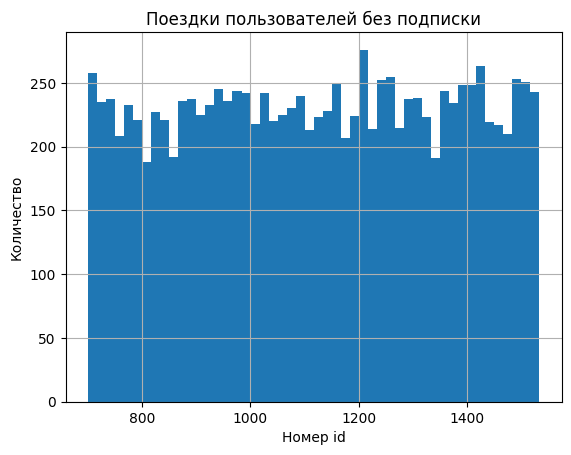

In [ ]:
data_go_free['user_id'].hist(bins=50)
pl.title("Поездки пользователей без подписки")
pl.xlabel("Номер id")
pl.ylabel("Количество")

Text(0, 0.5, 'Количество')

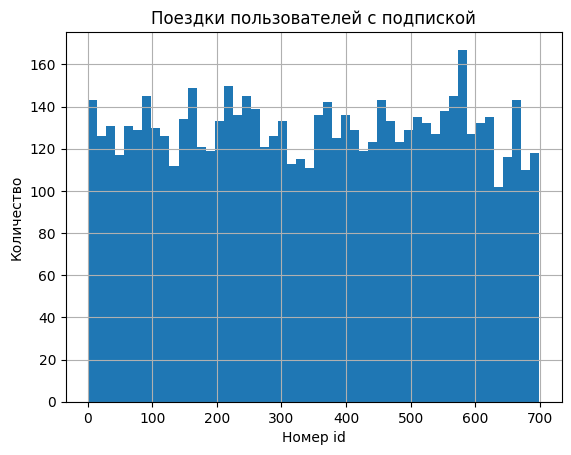

In [ ]:
data_go_ultra['user_id'].hist(bins=50)
pl.title("Поездки пользователей c подпиской")
pl.xlabel("Номер id")
pl.ylabel("Количество")

<font color='green'>🔄 Пользователи с подпиской имеют id номера до 700, пользователи без подписки имеют номера от 700. Ранее мы видели эту аномалию на графике, на котором было видно, что пользователи без подписки совершают больше поездок.

Text(0, 0.5, 'Количество')

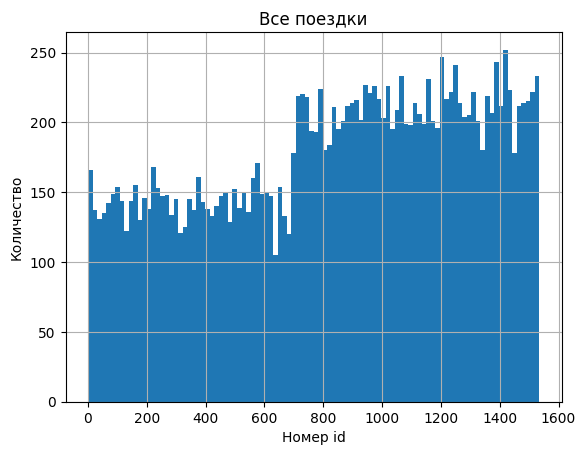

In [ ]:
rides_go['user_id'].hist(bins=100)
pl.title("Все поездки")
pl.xlabel("Номер id")
pl.ylabel("Количество")

<font color='blue'>🔄 Осталось исследовать аномалию №2. Distance - два ярко выраженных распределения.<br>
    Предположим, что данные распределения вызваны географическими факторами - городами.<br>
    Тогда, для отфильтрованных данных (по параметру "город") распределение останется одно. Проверим.

<Axes: >

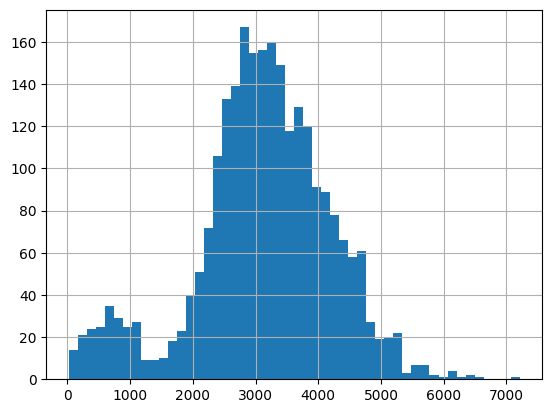

In [ ]:
Pjatigorsk = data_go_price.query('city == "Пятигорск"')
Pjatigorsk['distance'].hist(bins=50)

<font color='green'>🔄 Гипотеза оказалась неверной. Отфильтруем по датам.

<Axes: >

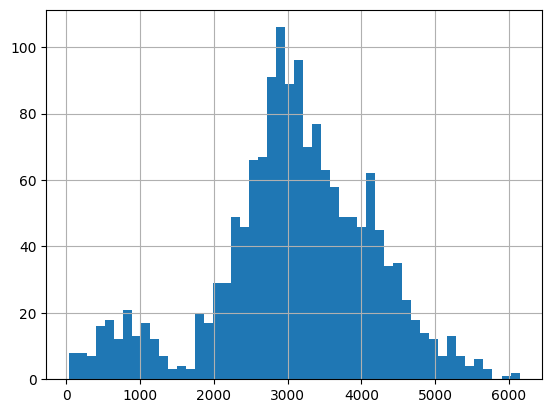

In [ ]:
June = data_go_price.query('month == 6')
June['distance'].hist(bins=50)

<font color='green'>🔄 Распределения остались. Вывод: факторы влияющие на распределения не отражены в имеющихся наборах данных. Как вариант, данные распределения могли появиться из-за использования техники низким с остаточным зарядом, но это не точно.

<font color='green'>🔄 Вывод по объединению данных:<br>
    1) Были объединены данные о пользователях и их поездках. Это позволит определить зависимости в поведении пользователей в зависимости от их статуса и других критериев, а также географического положения.<br>
    2) Объединенная таблица разбита на пользователей free и ultra.<br>
    3) Визуализированы расстояния - они имеют странную форму распределения, исследование которой не дало конкретного ответа на основании имеющихся данных. Для групп с подпиской и без подписки эти распределения одинаковы. Их появление может быть обусловлено использованием техники с низким уровнем заряда, но это не точно.<br>
    4) Визуализированы длительности. Длительность поездок подчинены закону нормального распределения. Пользователи без подписки совершают более короткие поездки, распределение смещено влево.<br>
    5) Поездки длительностью в 30 сек. - потерянные данные.<br>
    6) Пользователи без подписки совершают больше поездок.<br>

#### Шаг 5. Подсчёт выручки

<font color='green'> 5.1 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. <br>


In [ ]:
revenue_data = (
    data_go_price.groupby(['user_id', 'month'])
        .agg({'distance' : ['sum','count'], 'duration' : ['sum']}))

revenue_data.columns = ['sum_distance', 'count', 'sum_time_minut']
revenue_data.head(1)

,,sum_distance,count,sum_time_minut
user_id,month,,,
1,1,7027.511294,2,41.41664


<font color='green'> 5.2 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округлим до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26. <br>


In [ ]:
data_go_price.head(1)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.91914,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199


<div class="alert alert-block alert-danger">
Округлять необходимо каждую поездку, то есть в исходной таблице до агрегирования.


</div>

In [ ]:
# Округлим продолжительность поездок
data_go_price['duration'] = np.ceil(data_go_price['duration'])

# Добавим ещё три столбца
revenue = (
    data_go_price.groupby(['user_id', 'month'])
        .agg({'distance' : ['sum','count'], 'duration' : ['sum'],
             'minute_price' : ['min'], 'start_ride_price' : ['min'], 'subscription_fee' : ['min'],
              'subscription_type': ['min']
             }))

revenue.columns = (
    ['sum_distance', 'count', 'sum_time_minut', 'minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type'])

# Округлим продолжительность поездок  - ошибка
# revenue['sum_time_minut'] = np.ceil(revenue['sum_time_minut'])   - ошибка

# Посчитаем месячные траты пользователей как
# стоимость старта поездки ×  количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

revenue['expenses'] = (revenue['start_ride_price'] * revenue['count']
                       + revenue['minute_price'] * revenue['sum_time_minut']
                       + revenue['subscription_fee'])
revenue.head(10)

sum_distance  count  sum_time_minut  minute_price  \
user_id month                                                      
1       1       7027.511294      2            42.0             6   
        4        754.159807      1             7.0             6   
        8       6723.470560      2            46.0             6   
        10      5809.911100      2            32.0             6   
        11      7003.499363      3            56.0             6   
        12      6751.629942      2            28.0             6   
2       3      10187.723006      3            63.0             6   
        4       6164.381824      2            40.0             6   
        6       3255.338202      1            14.0             6   
        7       6780.722964      2            48.0             6   

               start_ride_price  subscription_fee subscription_type  expenses  
user_id month                                                                  
1       1                     0               199             ultra     451.0  
        4                     0               199             ultra     241.0  
        8                     0               199             ultra     475.0  
        10                    0               199             ultra     391.0  
        11                    0               199             ultra     535.0  
        12                    0               199             ultra     367.0  
2       3                     0               199             ultra     577.0  
        4                     0               199             ultra     439.0  
        6                     0               199             ultra     283.0  
        7                     0               199             ultra     487.0

<font color='green'>🔄 Вывод по подсчёту выручки. <br>
    Благодаря агрегированию данных были найдены:<br>
    1) Суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц;<br>
    2) Помесячные траты пользователей.

#### Шаг 6. Проверка гипотез

<font color='green'>
Выясним несколько важных моментов. <br>
6.1 Нужно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки. <br>
Определим достоверность гипотезы что пользователи с подпиской тратят больше времени на поездки чем без.


In [ ]:
#data_go_free = data_go_price.query('subscription_type == "free"')
#data_go_ultra = data_go_price.query('subscription_type == "ultra"')
data_go_price.head(1)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.91914,26.0,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199


<font color='green'>🔄
·	Нулевая гипотеза: средние значения <strike>трат</strike> длительностей поездок пользователей из двух групп равны.<br>
·	Альтернативная гипотеза: среднее значение  <strike>трат</strike> длительностей поездок пользователей с подпиской больше, чем среднее значение <strike>трат</strike>  длительностей поездок пользователей без подписки.


In [ ]:
array1 = data_go_ultra['duration'].values[:, None] # набор временных интервалов пользователей с подпиской ultra
array2 = data_go_free['duration'].values[:, None] # набор временных интервалов пользователей без подписки free

# задаём уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(array1, array2, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: [1.28040983e-34]
Отвергаем нулевую гипотезу


<font color='green'>
Полученное значение p-value (1.28040983e-34) меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской совершают более длительные поездки. Проверим.


In [ ]:
print('Средние данных наборов:', array1.mean(), array2.mean())

Средние данных наборов: 18.54198516280583 17.39090929866399


<font color='green'>
6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? <br>
Проверим гипотезу и сделаем выводы.


<font color='green'> 🔄 <br>
    Нулевая гипотеза - среднее расстояние одной поездки пользователя с подпиской равно 3130 метров. <br>
    Альтернативная гипотеза - среднее расстояние одной поездки пользователя с подпиской больше 3130 метров<br>
<br>
    «Среднее расстояние пробега больше 3130 метров » — так можно будет утверждать только в случае, если значение будет статистически значимо больше установленного параметра average_distance.<br>
Так как важно, чтобы полученное значение было не больше, то тест правый односторонний.


<div class="alert alert-block alert-warning">
<b>🔁Комментарий ревьюера:</b>

Гипотезы следует формулировать максимально точно и подробно, чтобы не было разночтений. Расстояние какой поездки равно 3130 метров? Какое расстояние больше 3130 метров?</div>

In [ ]:
array3 = data_go_ultra['distance'].values[:, None]

average_distance = 3130 # оптимальное с точки зрения износа самоката расстояние разового перемещения

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    array3,
    average_distance,
    alternative= 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: [0.91953688]
Не получилось отвергнуть нулевую гипотезу


<font color='green'>Получается, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров с уровнем статистической значимости в 5%. Проверим


In [ ]:
print('Среднее расстояний в наборе:', array3.mean())

Среднее расстояний в наборе: 3115.4453880370247


<font color='green'>
6.3 Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделаем вывод.

<font color='green'> Воспользуемся специальным методом для проверки гипотезы о равенстве
среднего двух генеральных совокупностей по взятым из них выборкам (Генеральные совокупности не зависят друг от друга.): <br>

<font color='green'> 🔄 <br>
    Нулевая гипотеза - помесячная выручка пользователей с подпиской и без подписки одинаковые. <br>
    Альтернативная гипотеза - выручка от пользователей с подпиской выше, чем от пользователей без подписки. <br>
Так как важно, чтобы полученное значение было не больше, то тест правый односторонний.


<div class="alert alert-block alert-danger">
А какой будет альтернативная гипотеза?

Нулевая гипотеза – это основное проверяемое предположение, которое обычно формулируется как отсутствие различий, отсутствие влияния фактора, отсутствие эффекта, равенство нулю значений выборочных характеристик и т. п.</div>

In [ ]:
#Разделим таблицу revenue на две: для пользователей с подпиской
revenue_ultra = revenue[revenue['subscription_type'] == 'ultra'] # отфильтруем пользователей с подпиской
array4 = revenue_ultra['expenses'].values[:, None] # набор помесячных трат пользователей с подпиской ultra

revenue_free = revenue[revenue['subscription_type'] == 'free'] # отфильтруем пользователей без подписки
array5 = revenue_free['expenses'].values[:, None] # набор помесячных трат пользователей без подписки

# задаём уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше», правосторонняя H1:
# «Среднее значение первой генеральной совокупности больше среднего значения второй генеральной совокупности».
results = st.ttest_ind(array4, array5, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: [1.88503944e-31]
Отвергаем нулевую гипотезу


<font color='green'>  Полученное значение p-value [1.88503944e-31] меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят в сервисе больше денег.<br>
   <br>
    Проверим.<br>

In [ ]:
print('Средние тарты пользователей: с подпиской', array4.mean(), 'и без подписки', array5.mean())

Средние тарты пользователей: с подпиской 362.7921906022502 и без подписки 328.6413651073845


<font color='green'> 6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

<font color='green'> 🔄 <br>
    Нужно использовать гипотезу о равенстве средних для зависимых (парных) выборок <br>
    Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, нужно применить метод scipy.stats.ttest_rel().<br>
    Ему достаточно передать всего два параметра: наборы данных до и после. <br>
    Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения, что соответствует условию задачи<br>



<font color='green'>🔄 Вывод по проверке гипотез. <br>
    1) Есть основания говорить, что пользователи с подпиской совершают более длительные поездки. С подпиской 18.5 минут, без подпискт 17.4 минут.<br>
    2) Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров с уровнем статистической значимости не менее 5%.<br>
    3) Есть основания говорить, что пользователи с подпиской тратят в сервисе больше денег. Средние тарты пользователей: с подпиской 362.8 и без подписки 328.6 рублей.<br>

#### Шаг 7. Распределения

<font color='green'> 7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Нужно использовать биномиальное распределение, которое описывает указанную ситуацию. Затем подобрать подходящее значение параметра N для заданного параметра p=0.1 с помощью графиков и метода cdf() , сформулировать вывод и ответ.


<font color='green'> Сколько нужно раздать купонов n, чтобы с 5% вероятностью получить  не менее 100 подписчиков? При условии что p=10% получивших купон становятся подписчиками. <br>
Аппроксимируем биномиальное распределение нормальным.<br>
Значение параметра n подберём так, чтобы вероятность была близка к 5%.<br>

In [ ]:
# задаём параметры биномиального распределения
n = 1169
p = 0.1

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma)

# считаем вероятность хвоста слева от X купонов
result = distr.cdf(100)

print(result)


0.04971489312694162


<BarContainer object of 1170 artists>

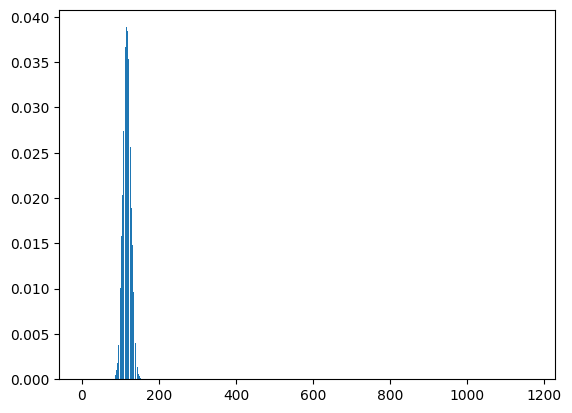

In [ ]:
n = 1169 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.bar(range(0, n + 1), distr)

<font color='green'>  Нужно раздать 1169 купонов, чтобы с вероятностью 95% получить не менее 100 подписчиков. Но столько пользователей free у компании нет.

In [ ]:
users_go.groupby('subscription_type')['subscription_type'].count()

subscription_type
free     835
ultra    699
Name: subscription_type, dtype: int64

<font color='green'> 7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.


In [ ]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma)

# считаем вероятность хвоста слева от X открытий push-a
result = distr.cdf(399500)

print(result)

0.15371708296369768


<font color='green'> Вероятность хвоста слева от X открытий push-a для запланированных 399500 открытий уведомления составляет 15%. <br>
    🔄 Вероятность того, что уведомление будет открыто менее 399,5 тыс. пользователей составляет 15%.

<BarContainer object of 1001 artists>

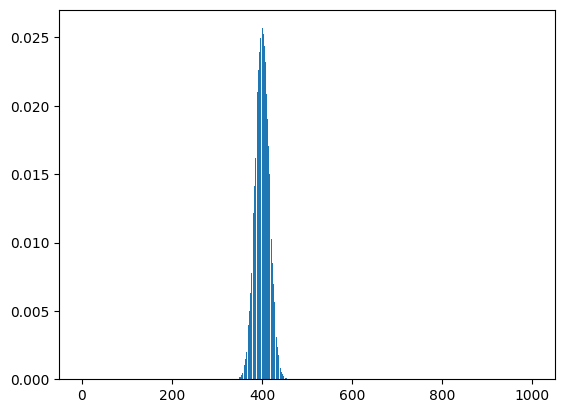

In [ ]:
n = 1000 # количество попыток
p = 0.4 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.bar(range(0, n + 1), distr)


<font color='green'> Построен график для 1000 попыток, если вероятность открытий равна 40%. Видно, что с 50% вероятностью будет 400 открытий push-уведомлений. Такой же характер будет для 1 млн. попыток: 400000 открытий с 50% вероятностью.


<div class="alert alert-block alert-warning">
Так какой все-таки будет вероятность того, что уведомление откроют не более 399,5 тыс. пользователей?

График необходимо строить именно по значениям условия задачи. Посчитанная вероятность для 1000 уведомлений не будет равна вероятности для 1 млн. уведомлений.</div>

<font color='green'>🔄 Вывод по распределениям. <br>
    1. Нужно раздать 1169 купонов пользователям без подписки, чтобы с вероятностью 95% получить не менее 100 подписчиков, при условии 10% конверсии.<br>
    2. Если привлекать пользователей через push уведомления, то  вероятность того, что уведомление будет открыто менее 399,5 тыс. раз составляет 15% на каждые 1 млн. уведомлений.<br>

<font color='green'><b>🔄 Итоговый вывод. <br>
    Обзор проведенной работы.</b><br>
<b>1 часть:<br>
Выводы по загрузке данных:</b> <br>
    -Строки с пропущенными данными отсутствуют<br>
    - Количество строк с данными о пользователях 1565, при том что строк с данными о поездках 18068.<br>
    - id номера двух баз соответствуют друг другу.<br>
    - Формат даты не соответствует формату pandas datetime64[ns]<br>
<br>
<b>2 часть:<br>
Вывод о результатах предобработки:</b>
    - Формат данных о датах поехдок в таблице rides_go исправлен на формат pandas datetime64[ns]. Данные о поездках собраны за 2021 год с 1-го января по 30 декабря. Создан новый столбец данных month (месяц поездки).
    - Найдены полные дубликаты о пользователях сервиса. Всего 31, что составляет 2% от общего количества. Удалены.
    - Пропусков данных в таблицах о пользователях и поездках - нет.<br>
<br>
<b>3 часть:<br>
Выводы по исследовательскому анализу данных:</b> <br>
    - Больше всего пользователей в Пятигорске, меньше всего в Москве;<br>
    - Всего сервисом пользуются в восьми городах: Пятигорске - 219; Екатеринбурге - 204; Ростове-на-Дону - 198; Краснодаре -        193; Сочи - 189; Омске - 183; Тюмени - 180; Москве - 168.
    - Пользователей с подпиской ultra - 699, без подписки free - 835;<br>
    - Средний возраст пользователя почти 25 лет, а в 40 уже почти никто не пользуется сервисом;<br>
    - 96% пользователей сервиса имеют возраст от 15 до 35 лет.<br>
    - В среднем проезжают 3 км, но бывает и до 6 км;<br>
    - Максимальное количество поездок в основной массе длится около 15-20 минут. Максимум 35 минут;<br>
    - Есть странности в данных, которые объяснить сложно без их объединения, такие как: <br>
    1) user_id - странное увеличение количества поездок для пользователей с id выше 700;<br>
    2) distance - два ярко выраженных распределения;<br>
    3) duration - странные поездки длительностью около 30 сек;<br>
    4) date - странная равномерность поездок. Зимой должно быть меньше;<br>
    5) month - без странностей;<br>
    <br>
<b>4 часть:<br>
Вывод по объединению данных:</b><br>
    1) Были объединены данные о пользователях и их поездках. Это позволило определить зависимости в поведении пользователей в зависимости от их статуса и других критериев, а также географического положения.<br>
    2) Объединенная таблица разбита на пользователей free и ultra.<br>
    3) Визуализированы расстояния - они имеют странную форму распределения, исследование которой не дало конкретного ответа на основании имеющихся данных. Для групп с подпиской и без подписки эти распределения одинаковы. Их появление может быть обусловлено использованием техники с низким уровнем заряда, но это не точно.<br>
    4) Визуализированы длительности. Длительность поездок подчинены закону нормального распределения. Пользователи без подписки совершают более короткие поездки, распределение смещено влево.<br>
    5) Поездки длительностью в 30 сек. - потерянные данные. Таких строк - 95.<br>
    6) <b>Пользователи без подписки совершают больше поездок.</b><br>
<br>
<b>5 часть:<br>
Вывод по подсчёту выручки.</b> <br>
    Благодаря агрегированию данных были найдены:<br>
    1) Суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц;<br>
    2) Помесячные траты пользователей.   
    
<b>6 часть:<br>
Вывод по проверке гипотез.</b> <br>
    1) Есть основания говорить, что пользователи с подпиской совершают более длительные поездки. С подпиской 18.5 минут, без подпискт 17.4 минут.<br>
    2) Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров с уровнем статистической значимости не менее 5%.<br>
    3) Есть основания говорить, что пользователи с подпиской тратят в сервисе больше денег. Средние тарты пользователей: с подпиской 362.8 и без подписки 328.6 рублей в месяц <br>   
<b>7 часть:<br>
Вывод по распределениям. </b><br>
    1. Нужно раздать 1169 купонов пользователям без подписки, чтобы с вероятностью 95% получить не менее 100 подписчиков, при условии 10% конверсии.<br>
    2. Если привлекать пользователей через push уведомления, то  вероятность того, что уведомление будет открыто менее 399,5 тыс. раз составляет 15% на каждые 1 млн. уведомлений.<br>

<font color='green'>🔄 <b> Главный вывод. Пользователи с подпиской более выгодные для компании.</b>